In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\folks\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
import json
import string
from bs4 import BeautifulSoup

table = str.maketrans("", "", string.punctuation)
stopwords = set(nltk.corpus.stopwords.words('english'))

sentences = []
labels = []
urls = []

with open("Sarcasm_Headlines_Dataset.json", 'r') as f:
    for line in f:
    # Remove leading/trailing whitespace and then decode JSON
        item = json.loads(line.strip())
        sentence = item['headline'].lower()
        sentence = sentence.replace(",", " , ")
        sentence = sentence.replace(".", " . ")
        sentence = sentence.replace("!", " ! ")
        sentence = sentence.replace("?", " ? ")
        sentence = sentence.replace("/", " / ")
        sentence = sentence.replace("-", " - ")
        soup = BeautifulSoup(sentence)
        sentence = soup.get_text()
        words = sentence.split()
        filtered_sentence = ""
        for word in words:
            word = word.translate(table)
            if word not in stopwords:
                filtered_sentence += word + " "
        label = item['is_sarcastic']
        link = item['article_link']
        sentences.append(filtered_sentence)
        labels.append(label)
        urls.append(link)

C:\Users\folks\AppData\Local\Temp\ipykernel_8536\1182359839.py:23: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence)


In [8]:
training_size = 23000
validation_size = 2500

training_sentences = sentences[:training_size]
training_labels = labels[:training_size]

validation_sentences = sentences[training_size:training_size+validation_size]
validation_labels = labels[training_size:training_size+validation_size]

testing_sentences = sentences[training_size+validation_size:]
testing_labels = labels[training_size+validation_size:]

In [9]:
vocab_size = 20000
max_length = 10
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

In [11]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)

In [12]:
wc = tokenizer.word_counts
print(wc)

OrderedDict([('former', 90), ('versace', 1), ('store', 44), ('clerk', 9), ('sues', 13), ('secret', 78), ('black', 230), ('code', 19), ('minority', 12), ('shoppers', 2), ('roseanne', 3), ('revival', 10), ('catches', 10), ('thorny', 3), ('political', 73), ('mood', 13), ('better', 100), ('worse', 34), ('mom', 163), ('starting', 37), ('fear', 39), ('sons', 35), ('web', 16), ('series', 53), ('closest', 5), ('thing', 126), ('grandchild', 2), ('boehner', 26), ('wants', 120), ('wife', 73), ('listen', 21), ('come', 92), ('alternative', 13), ('debt', 23), ('reduction', 4), ('ideas', 35), ('j', 41), ('k', 39), ('rowling', 5), ('wishes', 33), ('snape', 2), ('happy', 51), ('birthday', 57), ('magical', 25), ('way', 239), ('advancing', 2), ('worlds', 79), ('women', 289), ('fascinating', 3), ('case', 77), ('eating', 64), ('lab', 8), ('grown', 17), ('meat', 25), ('ceo', 56), ('send', 33), ('kids', 164), ('school', 207), ('work', 168), ('company', 78), ('top', 106), ('snake', 9), ('handler', 4), ('leave

### ลำดับของความถี่คำ

In [13]:
from collections import OrderedDict

newlist = (OrderedDict(sorted(wc.items(), key=lambda t: t[1], reverse=True)))
print(newlist)

OrderedDict([('new', 1318), ('trump', 1117), ('man', 1075), ('one', 469), ('year', 440), ('report', 434), ('area', 421), ('donald', 407), ('day', 398), ('u', 398), ('says', 385), ('woman', 378), ('first', 376), ('time', 365), ('like', 356), ('get', 346), ('old', 332), ('trumps', 331), ('life', 319), ('obama', 317), ('people', 311), ('house', 290), ('women', 289), ('white', 281), ('back', 278), ('still', 276), ('make', 275), ('clinton', 264), ('5', 260), ('world', 251), ('americans', 246), ('could', 241), ('years', 240), ('way', 239), ('family', 231), ('black', 230), ('study', 225), ('gop', 218), ('best', 215), ('bill', 211), ('american', 208), ('school', 207), ('would', 206), ('police', 206), ('watch', 206), ('3', 205), ('show', 205), ('really', 200), ('president', 198), ('home', 196), ('last', 194), ('video', 194), ('finds', 194), ('death', 193), ('cant', 193), ('know', 193), ('10', 192), ('things', 191), ('good', 191), ('going', 190), ('state', 189), ('hillary', 187), ('love', 184), 

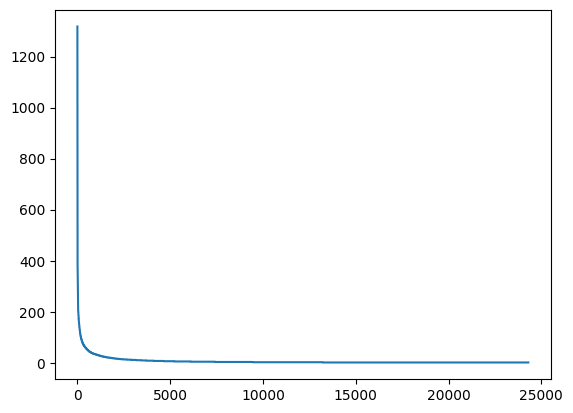

In [14]:
import matplotlib.pyplot as plt

xs = []
ys = []
curr_x = 1
for item in newlist:
    xs.append(curr_x)
    curr_x = curr_x + 1
    ys.append(newlist[item])

plt.plot(xs,ys)
plt.show()

In [15]:
import tensorflow as tf

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(20000, 7),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(x=training_padded, y=training_labels, epochs=50, validation_data=(validation_padded, validation_labels))

Epoch 1/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5564 - loss: 0.7567 - val_accuracy: 0.5696 - val_loss: 0.7344
Epoch 2/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5566 - loss: 0.7294 - val_accuracy: 0.5696 - val_loss: 0.7134
Epoch 3/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5663 - loss: 0.7098 - val_accuracy: 0.5704 - val_loss: 0.6988
Epoch 4/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5718 - loss: 0.6974 - val_accuracy: 0.5808 - val_loss: 0.6879
Epoch 5/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5930 - loss: 0.6872 - val_accuracy: 0.6144 - val_loss: 0.6792
Epoch 6/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6168 - loss: 0.6795 - val_accuracy: 0.6512 - val_loss: 0.6712
Epoch 7/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 968us/step - accuracy: 0.6363 - loss: 0.6696 - val_accuracy: 0.6708 - val_loss: 0.6630
Epoch 8/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6577 - loss: 0.6615 - val_accuracy: 

In [18]:
result = model.evaluate(testing_padded, testing_labels)
print(result)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - accuracy: 0.7882 - loss: 0.4929
[0.4805493652820587, 0.7948718070983887]


---

เนื่องจากทำมาทุกอย่างแล้วแต่ก็ยัง ไม่สามารถแก้ปัญหา Overfit ได้ เราจึงสำรวจข้อมูลก่อน

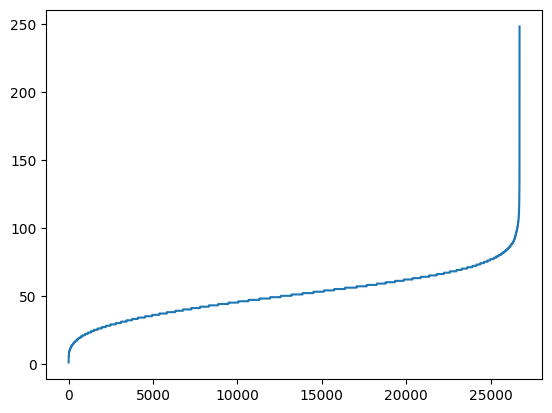

In [19]:
xs = []
ys = []
current_item = 1
for item in sentences:
    xs.append(current_item)
    current_item = current_item + 1
    ys.append(len(item))
newys = sorted(ys)

import matplotlib.pyplot as plt
plt.plot(xs, newys)
plt.show()


จะสังเกตว่ากราฟ บอกว่าส่วนใหญ่มีน้อยกว่า 100 คำ ดังนั้นการกำหนดความยาวประโยคที่ 100 ขึ้นไป จะทำให้มีช่องว่างเกินไป

In [20]:
sentences = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night", "TensorFlow book will be a best seller"]

sequences = tokenizer.texts_to_sequences(sentences)
print(sequences)

padded = pad_sequences(sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)
print(padded)

[[1, 805, 1, 754, 19187, 1, 1, 2598, 309, 1, 92], [119, 1, 1187, 156, 2652, 3245, 1, 1547, 148], [1, 231, 1, 1, 1, 40, 15387]]
[[    1   805     1   754 19187     1     1  2598   309     1]
 [  119     1  1187   156  2652  3245     1  1547   148     0]
 [    1   231     1     1     1    40 15387     0     0     0]]


In [21]:
print(model.predict(padded))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[0.81734014]
 [0.49905935]
 [0.25677085]]


---

### Embbedding Projector

In [22]:
reversed_word_index = dict([(value, key) for (key, value) in word_index.items()])

e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

print(reversed_word_index[2])
print(weights[2])

(20000, 7)
new
[-0.06219138 -0.06166198 -0.10874007 -0.05850728  0.08140498 -0.03559492
  0.05067393]


In [23]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reversed_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

---

### Using the Pre-trained Embedding from tensorflow_hub

In [40]:
import tensorflow_hub as hub
import tensorflow as tf

hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", 
                           output_shape=[20], input_shape=[], dtype=tf.string, trainable=False)

model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x00000239AFF34C90> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)

In [31]:
import json
import string
from bs4 import BeautifulSoup

table = str.maketrans("", "", string.punctuation)
stopwords = set(nltk.corpus.stopwords.words('english'))

sentences = []
labels = []
urls = []

with open("Sarcasm_Headlines_Dataset.json", 'r') as f:
    for line in f:
    # Remove leading/trailing whitespace and then decode JSON
        item = json.loads(line.strip())
        sentence = item['headline'].lower()
        sentence = sentence.replace(",", " , ")
        sentence = sentence.replace(".", " . ")
        sentence = sentence.replace("!", " ! ")
        sentence = sentence.replace("?", " ? ")
        sentence = sentence.replace("/", " / ")
        sentence = sentence.replace("-", " - ")
        soup = BeautifulSoup(sentence)
        sentence = soup.get_text()
        words = sentence.split()
        filtered_sentence = ""
        for word in words:
            word = word.translate(table)
            if word not in stopwords:
                filtered_sentence += word + " "
        label = item['is_sarcastic']
        link = item['article_link']
        sentences.append(filtered_sentence)
        labels.append(label)
        urls.append(link)

C:\Users\folks\AppData\Local\Temp\ipykernel_8536\1182359839.py:23: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence)


In [32]:
training_size = 24000
training_sentences = sentences[:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[:training_size]
testing_labels = labels[training_size:]

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")

# Fit the tokenizer on the training sentences
tokenizer.fit_on_texts(training_sentences)

# Convert the sentences to sequences of integers
training_sequences = tokenizer.texts_to_sequences(training_sentences)

# Pad the sequences so they all have the same length
training_padded = pad_sequences(training_sequences, maxlen=100, padding='post', truncating='post')

# Convert the labels to a numpy array
training_labels = np.array(training_labels)


In [39]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353 (1.38 KB)

 Trainable params: 353 (1.38 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Now you can train your model
model.fit(training_padded, training_labels, epochs=10)

Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("sequential_4_1/Cast:0", shape=(32, 100), dtype=string). Expected shape (None,), but input has incompatible shape (32, 100)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 100), dtype=int32)
  • training=True
  • mask=None